In [2]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plta
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph import networks
import voxelmorph as vxm
from tqdm.notebook import trange
from tqdm.notebook import tqdm
import nibabel as nib
import imageio
from matplotlib import pyplot as plt
import pathlib

In [4]:
%env CUDA_VISIBLE_DEVICES=0
# %env PYTORCH_NO_CUDA_MEMORY_CACHING=1
gpus_list = ''
for i in range(torch.cuda.device_count()):
    used,all=torch.cuda.mem_get_info(device=i)
    torch.ones((1024*4,1024,1024)).to(device=i)
    # torch.cuda.caching_allocator_alloc(100000,i)
    if used/all >=0.80:
        gpus_list+=f'{i},'
    # torch.cuda.empty_cache()
gpus_list[:-1]

env: CUDA_VISIBLE_DEVICES=0


'0'

In [5]:
paths = list(pathlib.Path('/data01/junyi/datasets/HCP_100').glob('**/FA*'))

In [6]:
TOMpath = list((paths[0].parent/'tractseg_output/TOM_new').glob('AF*'))[0]
segpath = (paths[0].parent/'tractseg_output/bundle_segmentations').glob('AF*')
FApath = list(paths[0].parent.glob('FA_MNI*'))[0]
seg = np.sum(np.stack([nib.load(i).get_fdata() for i in segpath]),0)
FA = nib.load(FApath)
FA_image = FA.get_fdata()*seg
indice_down = np.array(FA_image.shape)//2-np.array([128//2, 160//2, 128//2])
print(indice_down)
indice_up =(np.array(FA_image.shape)//2)+np.array([128//2, 160//2, 128//2])
crop_img=FA_image[indice_down[0]:indice_up[0], indice_down[1]:indice_up[1], indice_down[2]:indice_up[2]]
crop_img = nib.Nifti1Image(crop_img, FA.affine, FA.header)
# nib.save(crop_img,'FA.nii.gz')

[8 7 8]


In [3]:
vol_shape = (128, 160, 128)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
atlas = torch.empty(3, *vol_shape)
snapshot_path = 'snapshot0_AF.pt'
snapshot = torch.load(snapshot_path,map_location='cpu')
networks.TemplateCreation(snapshot["MODEL_STATE"])
# model = networks.TemplateCreation(vol_shape,atlas,nb_unet_features=[enc_nf, dec_nf],altas_feats=3,src_feats=3)
# model.load_state_dict(snapshot["MODEL_STATE"])
# altas = model.atlas.squeeze().detach().numpy().transpose(1,2,3,0)

FileNotFoundError: [Errno 2] No such file or directory: 'snapshot0_AF.pt'

In [8]:
mask = (np.max(np.abs(altas),axis=-1,keepdims=True) <= 1e-2)

In [9]:
altas[np.concatenate([mask for _ in range(3)],-1)] = 0

In [11]:
crop_img = nib.Nifti1Image(altas[::-1], FA.affine, FA.header)
nib.save(crop_img,'AF_atlas.nii.gz')

In [4]:
image_lst  = [(np.clip(np.abs(altas[...,::-1,i]), 0, 1)*255).T.astype('uint8') for i in range(altas.shape[-1])]
imageio.mimwrite('AF.gif',image_lst,format='GIF',duration=0.1, loop=0)

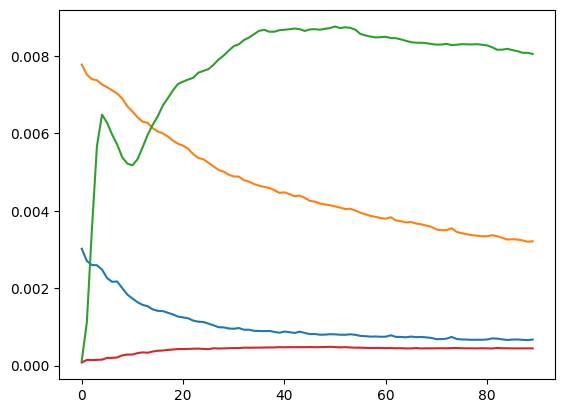

In [5]:
loss = np.load('noalign_loss_his.npy')
plt.plot((loss[:]))

In [1]:
import pathlib
path = pathlib.Path('../OASIS')
subj_lst_m = [str(f/'norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]

In [5]:
# prepare data
vols = [nib.load(f).get_fdata() for f in subj_lst_m]
x_vols = np.stack(vols, 0)
vol_shape = (256, 192, 224)
device = torch.device(2)

In [16]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, img_data, transform=None, ):
        self.img_data = img_data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        image = self.img_data[idx, np.newaxis, ...]
        if self.transform:
            image = self.transform(image)
        return image

In [17]:
dataset = MRIDataset(x_vols,)

In [18]:
from torch.utils.data import DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    torch.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(10086)
train_dataloader = DataLoader(dataset,batch_size=1,sampler=torch.utils.data.RandomSampler(dataset),generator=g,worker_init_fn=seed_worker)

In [9]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

In [10]:
atlas = torch.mean((torch.from_numpy(dataset.img_data[:10])),dim=0).squeeze().unsqueeze(0)

In [11]:
model = torch.compile(networks.TemplateCreation(vol_shape,atlas,nb_unet_features=[enc_nf, dec_nf])).to(device)

In [12]:
image_loss_func = nn.MSELoss()
neg_loss_func = lambda _,y_pred: image_loss_func(y_pred, torch.stack([model.atlas for _ in range(y_pred.shape[0])]))
mean_flow_loss = lambda _,y_pred: torch.square(y_pred).mean()
losses = [image_loss_func, neg_loss_func, mean_flow_loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 0.1, 0.01]

In [13]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4,eps=1e-07)

In [14]:
loss_his = []
step = 100

In [19]:
for _ in trange(1500):
    loss_epoch = 0

    for batch, (train_features) in enumerate(train_dataloader):
        optimizer.zero_grad()
        train_features = train_features.to(device)
        batch_size = train_features.shape[0]
        output = model(train_features)
        output_p = [train_features,None,None,None]

        loss = torch.stack([losses[i](output_p[i],output[i])*loss_weights[i] for i in range(4)])

        loss.sum().backward()
        optimizer.step()
        loss_epoch+=loss
        if (batch+1)%step == 0:
            break
    loss_his.append([loss_epoch[i].item()/(batch+1) for i in range(4)])

  0%|          | 0/1500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
atlas = model.atlas.cpu().detach()

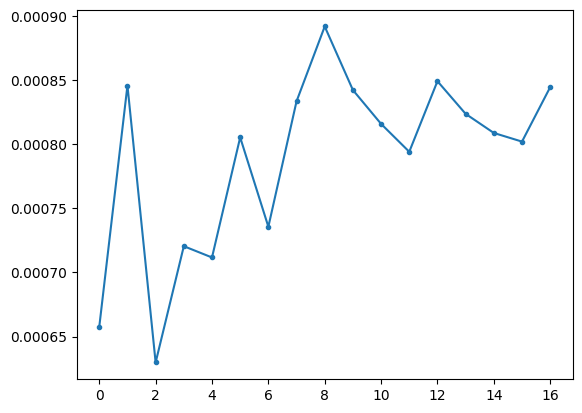

In [20]:
ls=plt.plot(np.array(loss_his).mean(1),'.-')

In [22]:
atlas.shape

torch.Size([1, 160, 192, 224])

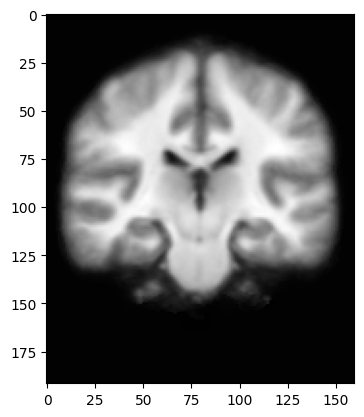

In [25]:
plt.imshow(atlas[0,...,100].T,cmap='gray')